In [1]:
from operator import iadd
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Display all rows
pd.set_option('display.max_rows', None)

In [3]:
# Get data
df = pd.read_json('http://localhost:5000/api/get/allentries')

In [4]:
# Drop irrelevant or bad entries/columns
df = df[df['format'] != 'Prison visit']
df = df[[bool(tags) for tags in df['tags']]]
df = df[[(date is not None and date >= '2015-01-01') for date in df['date_received']]]
df = df.filter(['eid', 'date_received', 'facility', 'tags'])

In [5]:
# Format dates to Python datetime
df['date_received'] = pd.to_datetime(df['date_received'])

In [6]:
# Get count of categories
categories = df['tags'].apply(lambda tags: pd.Series([tag['name'] for tag in tags]).value_counts()).sum()
categories = categories.to_frame()
categories.columns = ['count']
categories['percentage'] = categories['count'] * 100 / categories['count'].sum()
categories.sort_values(by='count', ascending=False)

,count,percentage
Operations,963.0,44.853284
Health & Well-being,372.0,17.326502
Procedural,334.0,15.556591
Interpersonal,307.0,14.299022
Services,138.0,6.427573
Economics,33.0,1.537028


In [7]:
# Get count of issues
issues = df['tags'].apply(lambda tags: pd.Series(reduce(iadd, (tag['subtags'] for tag in tags))).value_counts()).sum()
issues = issues.to_frame()
issues.columns = ['count']
issues['percentage'] = issues['count'] * 100 / issues['count'].sum()
issues.sort_values(by='count', ascending=False)

,count,percentage
Survey response,801.0,36.692625
Medical,269.0,12.322492
Parole,218.0,9.986257
Staff abuse,137.0,6.275767
SvP,80.0,3.664682
Discipline,58.0,2.656894
Programs,53.0,2.427852
Grievance,50.0,2.290426
COVID-19,39.0,1.786532
Mental health,33.0,1.511681


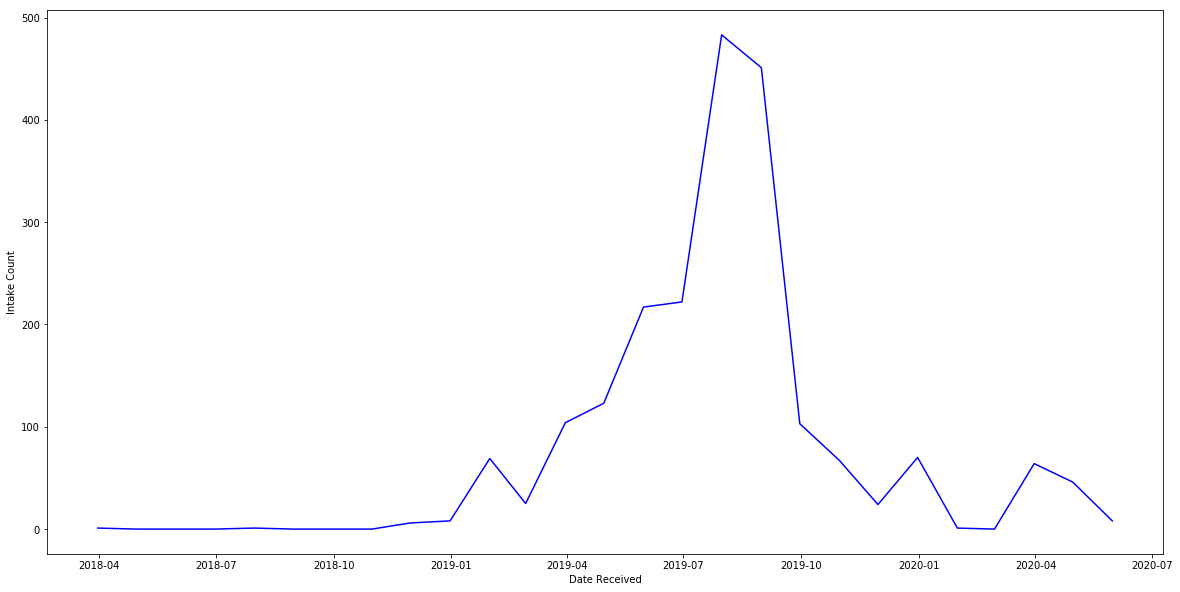

In [8]:
# Plot overall intake over time
df_tmp = df[:]
df_tmp.index = df_tmp['date_received']
df_tmp = df_tmp.groupby(pd.Grouper(freq='M')).count()

plt.figure(figsize=(20,10))
plt.xlabel('Date Received')
plt.ylabel('Intake Count')
plt.plot_date(df_tmp.index, df_tmp['eid'], '-b')

In [9]:
# Flatten
df = (pd.concat({i: pd.json_normalize(x) for i, x in df.pop('tags').items()})
        .reset_index(level=1, drop=True)
        .join(df)
        .reset_index()
     )
df.index = df['date_received']

In [10]:
# Format for categories chart
df_cat = df[:]
df_cat = (df_cat.groupby([pd.Grouper(freq='M'), 'name'])
                .count()
                .filter(['name', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )

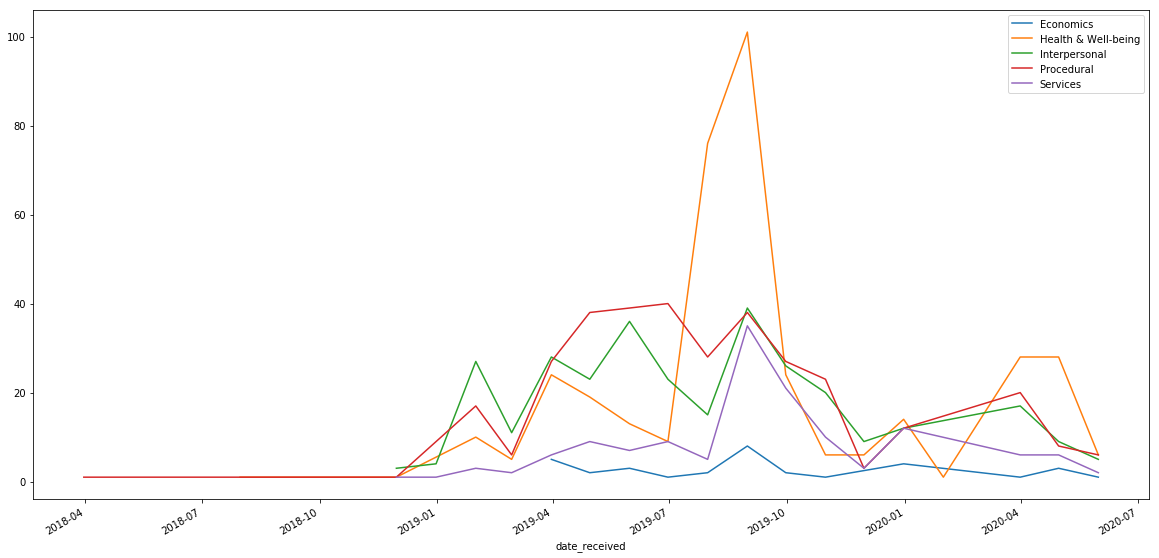

In [11]:
# Plot categories over time
fig, ax = plt.subplots()
for key, data in df_cat[df_cat['name'] != 'Operations'].groupby('name'):
    data.plot(x='date_received', y='count', ax=ax, label=key, figsize=(20,10))

In [12]:
# Flatten subtags
df = df.reset_index(drop=True)
df_flat = pd.DataFrame([[i, x] for i, y in df['subtags'].apply(list).iteritems() for x in y],
                       columns=['I', 'subtags'])
df_flat = df_flat.set_index('I')
df_iss = df.drop('subtags', 1).merge(df_flat, left_index=True, right_index=True)

In [13]:
# Format for issues chart
df_iss.index = df_iss['date_received']
df_iss = (df_iss.groupby([pd.Grouper(freq='M'), 'subtags', 'name'])
                .count()
                .filter(['subtags', 'eid'])
                .rename(columns={'eid': 'count'})
                .reset_index()
         )

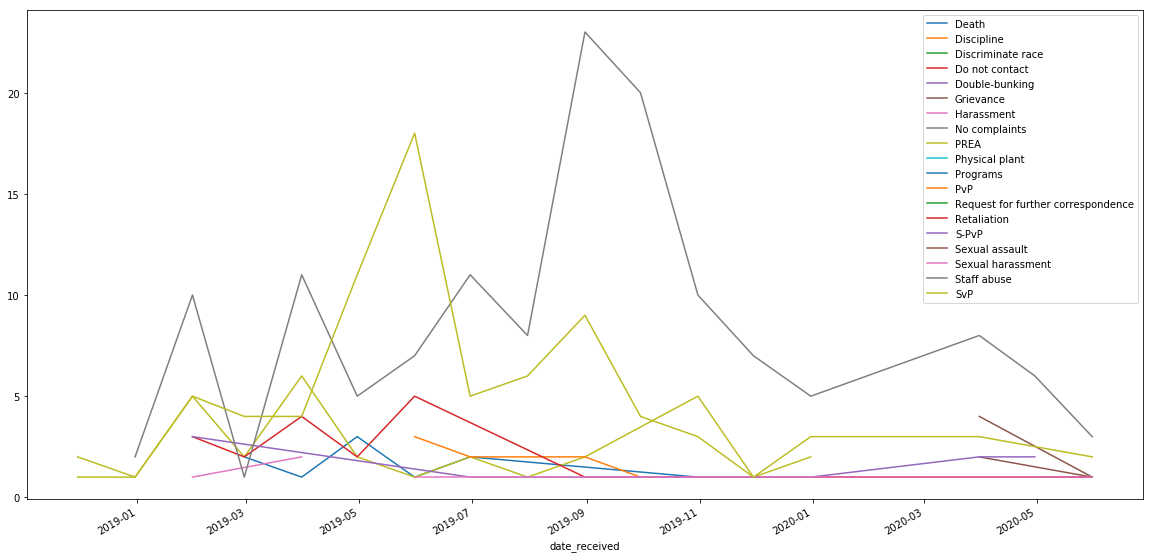

In [14]:
# Plot interpersonal issues over time
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Interpersonal'].groupby('subtags'):
    data.plot(x='date_received', y='count', ax=ax, label=key, figsize=(20,10))

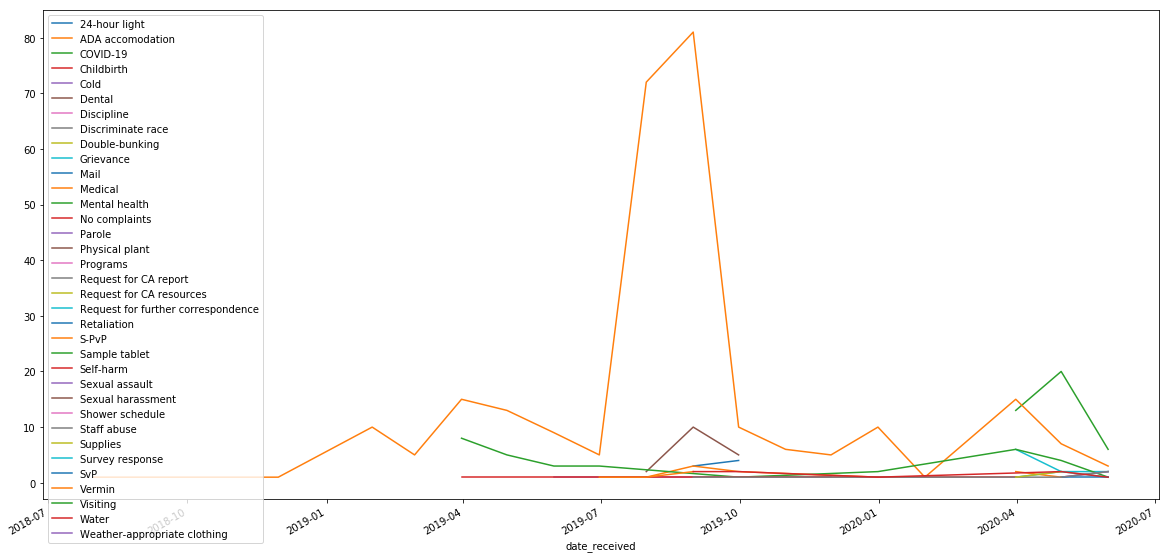

In [15]:
# Plot health & well-being issues over time
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Health & Well-being'].groupby('subtags'):
    data.plot(x='date_received', y='count', ax=ax, label=key, figsize=(20,10))

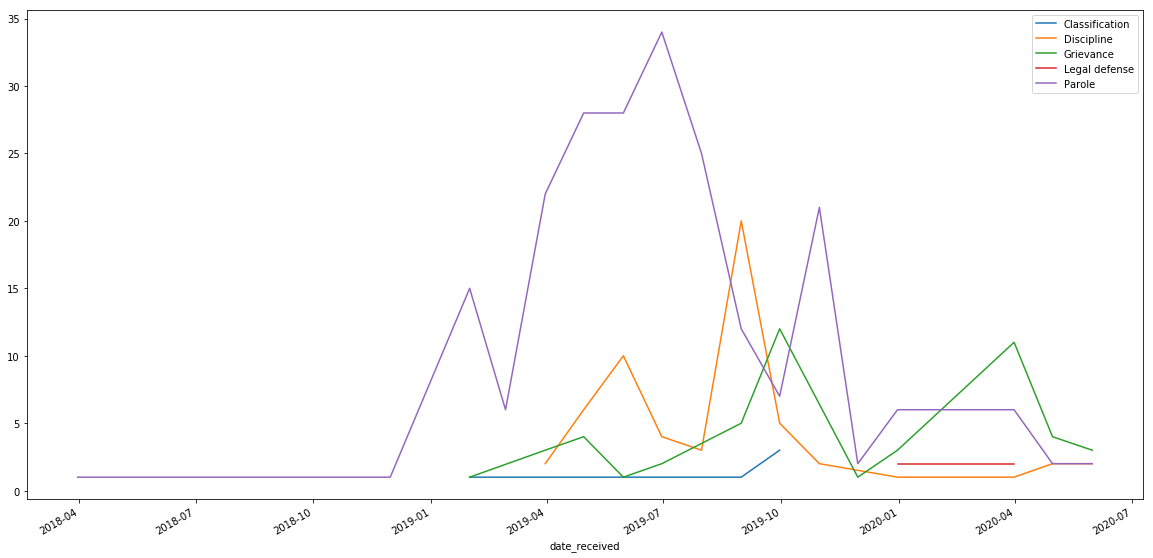

In [16]:
# Plot procedural issues over time
fig, ax = plt.subplots()
for key, data in df_iss[df_iss['name'] == 'Procedural'].groupby('subtags'):
    data.plot(x='date_received', y='count', ax=ax, label=key, figsize=(20,10))